# Data Analysis

- [Data Viewer](#Data-Viewer)
- [Custom Dataset & DataLoader](#Custom-Dataset-&-DataLoader)

### DirectoryStructure

```
.
├── data
│   ├── eastpac
│   │   ├── ...
│   │   └── eastpac_goes16_2017_308_2140.nc
│   └── natlantic
│       ├── ...
│       └── natlantic_goes16_2017_308_1810.nc
├── notebooks
│   └── stock-analysis.ipynb
└── src
    └── read_region.py
```

In [219]:
import sys
sys.path.append('../src')

import os.path
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import torch

from torchvision import transforms

import read_region as rr
import goesdataset as gd

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rc('font', family='serif', size=11)

# Data Viewer

In [3]:
def normalize(X):
    
    Xmin = np.min(X, axis=tuple([0, 2, 3])).reshape(1, X.shape[1], 1, 1)
    Xmax = np.max(X, axis=tuple([0, 2, 3])).reshape(1, X.shape[1], 1, 1)
 
    return (X - Xmin)/(Xmax - Xmin)

def square_data(X):
    nnew  = min(X.shape[2], X.shape[3])
    return X[:, :, 0:nnew, 0:nnew]

def imshow16(X, figsize=(8, 4)):
    fig, axs = plt.subplots(4, 4, figsize=figsize)
    [ax.set_axis_off() for ax in axs.ravel()]

    c = 0
    for i in range(4):
        for j in range(4):
            im = axs[i, j].imshow(X[:,c:c+1,...].reshape(X.shape[-2], X.shape[-1]), 
                                  interpolation='nearest', cmap='viridis')
            c += 1

    fig.tight_layout()
    fig.colorbar(im, ax=axs.ravel().tolist())

    plt.show()
    
def showfile(filename, square=False):
    if not os.path.exists(filename):
        print('ERROR: path to file does not exist!')
    else:
        cData = rr.read_region(filename, channels=True, geo=False, retrievals=False)

        X = np.array(cData['c00'])
        X = np.expand_dims(np.moveaxis(X, 2, 0), axis=0)
        
        figsize = (8, 4)
        
        if square or 'east' in filename:
            X = square_data(X)
            figsize = (6, 5)
        
        X = normalize(X)
        print(X.shape, np.min(X), np.max(X))
        
        imshow16(X, figsize=figsize)

In [4]:
volume = '../data'

## Northern Atlantic Ocean

In [8]:
showfile(volume + '/natlantic/natlantic_goes16_2017_308_1410.nc')

ERROR: path to file does not exist!


## Eastern Pacific Ocean

(1, 16, 20, 20) 0.0 1.0


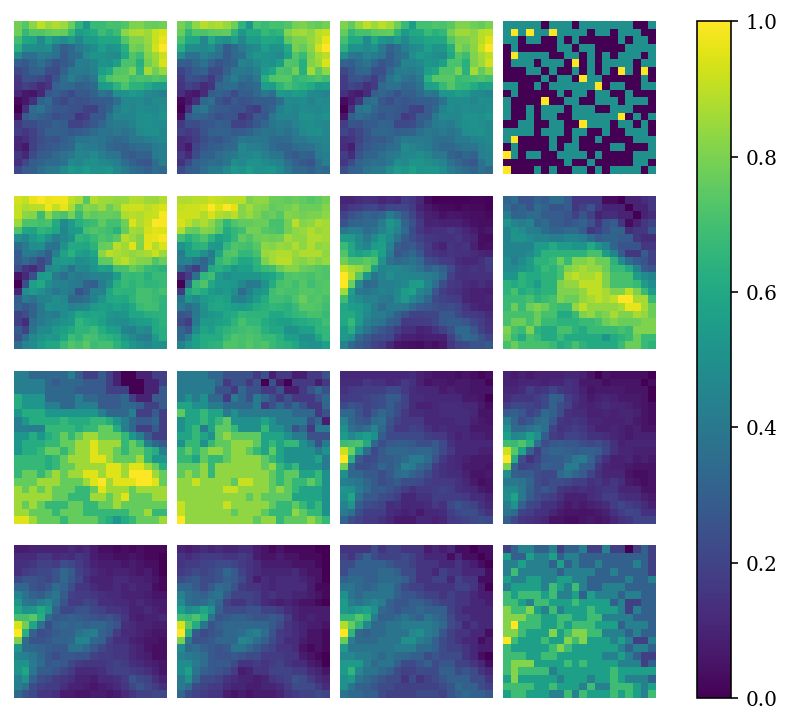

In [5]:
showfile('/s/chopin/l/grad/stock/data/eastpac2_20x20/eastpac2_goes16_2017_306_2140_210.nc')

# Custom Dataset & DataLoader

In [4]:
eastpac = gd.GOESDataset(root_dir='../data/subset-copy/',
                         transform=transforms.Compose([
                                gd.Square(), gd.ToTensor()
                         ]))
eastpac

Dataset GOESDataset
Number of datapoints: 256
Root location: ../data/subset-copy/
Compose(
    Square()
    ToTensor()
)

In [11]:
train_loader = torch.utils.data.DataLoader(eastpac, batch_size=3)

## Standardize?

In [12]:
def _standardizeX(self, X):
    result = (X - self.Xmeans) / self.XstdsFixed
    result[:, self.Xconstant] = 0.0
    return result

def _unstandardizeX(self, Xs):
    return self.Xstds * Xs + self.Xmeans

def _setup_standardize(self, X, T):
    self.Xmeans = X.mean(axis=0)
    self.Xstds = X.std(axis=0)
    self.Xconstant = self.Xstds == 0
    self.XstdsFixed = copy.copy(self.Xstds)
    self.XstdsFixed[self.Xconstant] = 1

In [5]:
means = torch.stack([eastpac[i][0].mean(1).mean(1) for i in range(len(eastpac))])
means = means.mean(0)

stds = torch.stack([eastpac[i][0].std(1).std(1) for i in range(len(eastpac))])
stds = stds.std(0)

means, stds

(tensor([0.2933, 0.2484, 0.2459, 0.0079, 0.3126, 0.3294, 0.9677, 0.9866, 0.9863,
         0.9884, 0.9789, 0.9818, 0.9774, 0.9785, 0.9803, 0.9860],
        dtype=torch.float64),
 tensor([0.0141, 0.0151, 0.0158, 0.0138, 0.0148, 0.0144, 0.0028, 0.0013, 0.0017,
         0.0023, 0.0034, 0.0026, 0.0034, 0.0035, 0.0035, 0.0030],
        dtype=torch.float64))

In [6]:
eastpac = gd.GOESDataset(root_dir='/s/chopin/l/grad/stock/data/eastpac2_20x20/',
           transform=transforms.Compose([
                gd.Square()
           ]))
eastpac

Dataset GOESDataset
Number of datapoints: 219904
Root location: /s/chopin/l/grad/stock/data/eastpac2_20x20/
Compose(
    Square()
)

In [9]:
top = np.zeros(16)
for i in range(len(eastpac)):
    X, T, F = eastpac[i]
    top = np.maximum(top, np.max(X, axis=tuple([1, 2])))
top

array([  1.23364961,   1.1933322 ,   1.20698297,   0.77238023,
         0.74793577,   0.57047564, 313.15881348, 256.77209473,
       264.97137451, 272.53656006, 294.66796875, 276.41287231,
       297.76239014, 297.10894775, 294.52630615, 279.70178223])

In [10]:
eastpac_full = gd.GOESDataset(root_dir='/s/chopin/l/grad/stock/data/eastpac2_20x20/',
                         transform=transforms.Compose([
                                gd.Square(), gd.ToTensor()
                         ]))

means = torch.stack([eastpac_full[i][0].mean(1).mean(1) for i in range(len(eastpac_full))])
means = means.mean(0)

stds = torch.stack([eastpac_full[i][0].std(1).std(1) for i in range(len(eastpac_full))])
stds = stds.std(0)

means, stds

TypeError: 'NoneType' object is not subscriptable

## Explore

In [9]:
def save_1(X, filename, title):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)

    im = ax.imshow(X.reshape(X.shape[-2], X.shape[-1]),
                          interpolation='nearest', cmap='viridis')

    ax.set_title(title)
    fig.colorbar(im)
    plt.show()

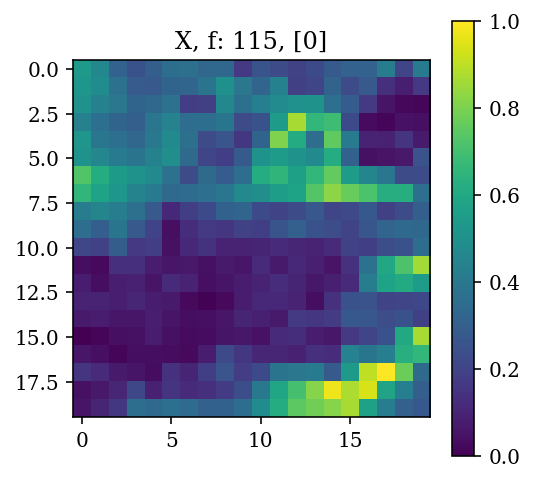

In [10]:
n = 115
ch = 0
o_filename = 'somewhere'
X = train_loader.dataset[n][0][ch:ch+1,...]
save_1(X, o_filename, f'X, f: {n}, [{ch}]')

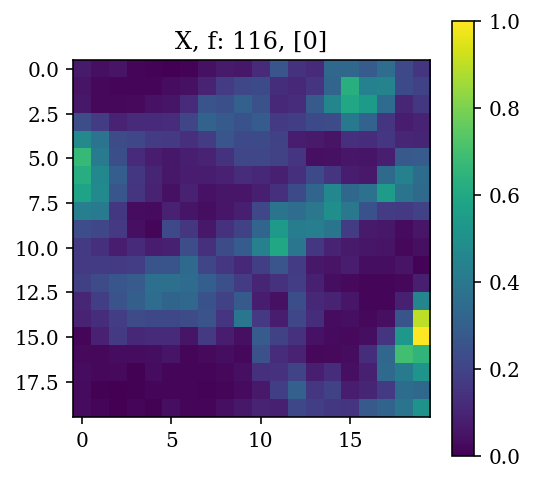

In [11]:
n = 116
ch = 0
o_filename = f'../media/{str(n)}_original'
X = train_loader.dataset[n][0][ch:ch+1,...]
save_1(X, o_filename, f'X, f: {n}, [{ch}]')

## HDFS

In [24]:
filename = volume + '/subset-copy/eastpac2_goes16_2017_331_1900_156.nc'
cData = rr.read_region(filename, channels=True, geo=False, retrievals=True)
X, T = cData['c00'], np.array(cData['ctype'])
X.shape, T.shape

((20, 20, 16), (20, 20))

In [25]:
X = np.expand_dims(np.moveaxis(X, 2, 0), axis=0)
X = square_data(X)
X = normalize(X)[0, ...]

In [26]:
nnew = min(T.shape[0], T.shape[1])
T = T[0:nnew, 0:nnew]
T.shape

(20, 20)

In [27]:
i = 0
T = T[i:i+20,i:i+20]
T

array([[0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [29]:
counts = np.bincount(T.flatten())
label = np.argmax(counts)
label

0

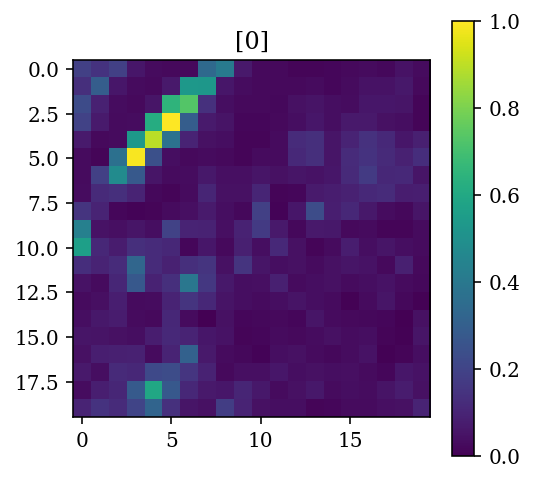

In [30]:
ch = 0
X = X[ch:ch+1,i:i+20,i:i+20]
save_1(X, '', f'[{ch}]')

$20x20 => 1x2$

In [31]:
a = np.array( [[-0.4, 0.25], 
               [-0.3, 0.2], 
               [-0.2, 0.21]] )

b = np.array( [[0.5, 0.4], 
               [0.4, 0.2], 
               [0.45, 0.21]] )

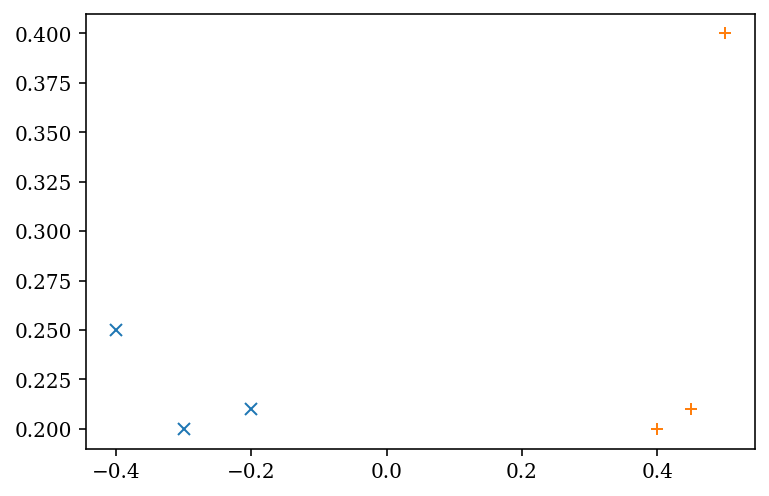

In [32]:
plt.plot(a[:,:1], a[:,1:], 'x')
plt.plot(b[:,:1], b[:,1:], '+');

# PCA/tSNE on RAW Data

In [35]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pylab as pl

In [36]:
X, T = [], []
for i in range(len(eastpac)):
    X.append(eastpac[i][0][0, ...].flatten().numpy())
    T.append(eastpac[i][1].item())

In [37]:
components = PCA(n_components=2).fit_transform(X)
embeded = TSNE(n_components=2).fit_transform(X)

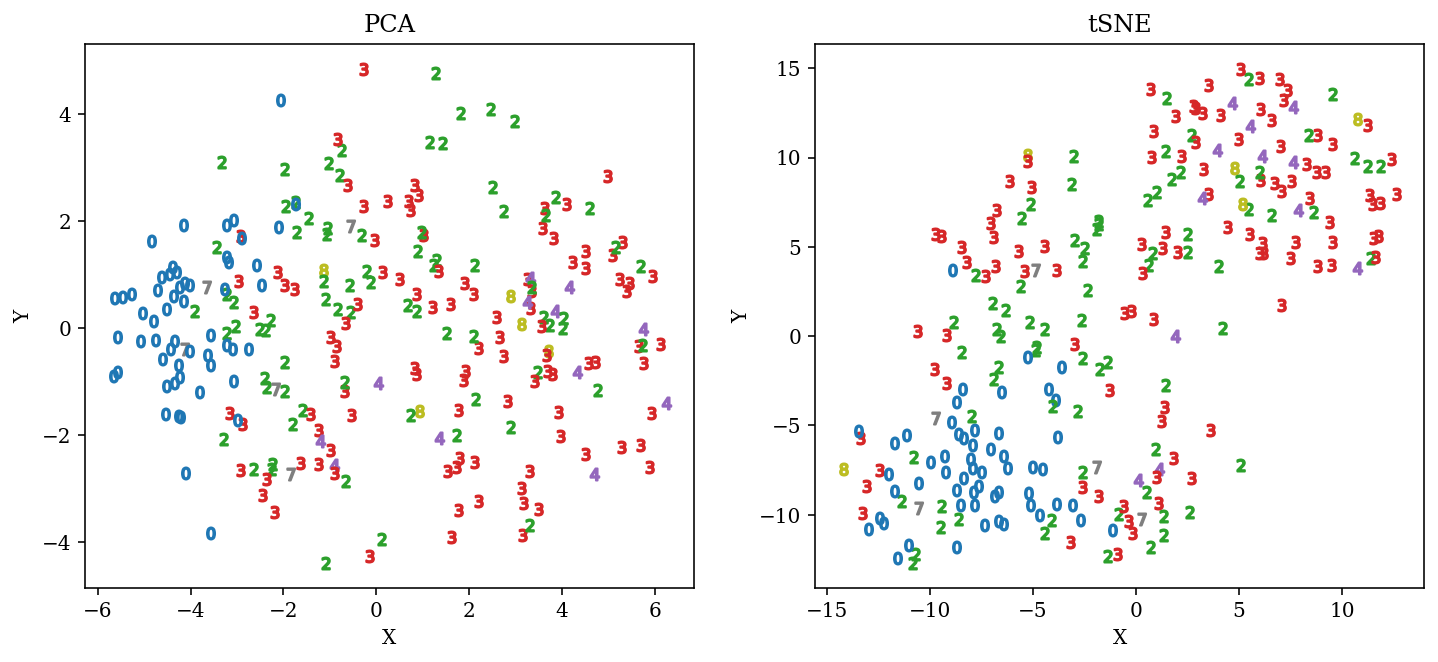

In [38]:
COLORS = pl.cm.tab10(np.linspace(0, 1, 10))

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)

for i in range(len(X)):
    ax.plot(components[i, 0], components[i, 1], 
            marker='${}$'.format(T[i]), c=COLORS[T[i]])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('PCA')

ax = fig.add_subplot(1, 2, 2)

for i in range(len(X)):
    ax.plot(embeded[i, 0], embeded[i, 1], 
            marker='${}$'.format(T[i]), c=COLORS[T[i]])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('tSNE')

plt.show()

# Labeling

In [268]:
filename = '/s/chopin/l/grad/stock/data/eastpac2_20x20/eastpac2_goes16_2017_322_1900_156.nc'
cData = rr.read_region(filename, channels=True, geo=False, retrievals=True)
X, T = cData['c00'], np.array(cData['ctype'])
X = np.moveaxis(X, 2, 0)[ch:ch+1,...]
print(X.shape, T.shape)

(1, 20, 20) (20, 20)


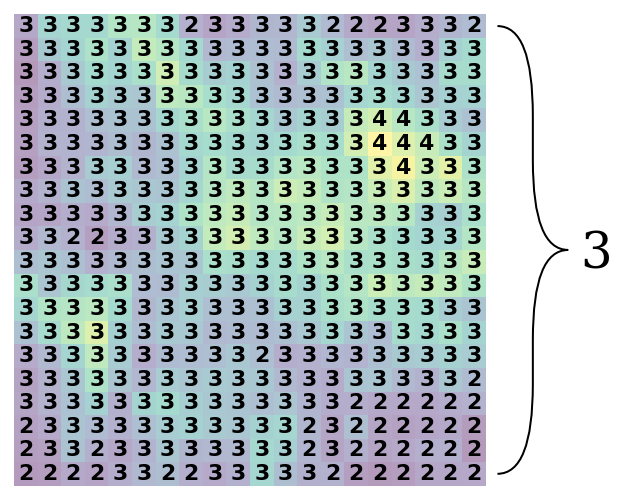

In [269]:
def CurlyBrace(ll_corner=(0, 0), width=1, height=1):
    Path = mpath.Path
    verts = np.array([(0, 0), (.5, 0), (.5, .2), (.5, .3), (.5, .5), (1, .5), (.5, .5), (.5, .7), (.5, .8), (.5, 1), (0, 1)])
    verts[:, 0] *= width
    verts[:, 1] *= height
    verts[:, 0] += ll_corner[0]
    verts[:, 1] += ll_corner[1]

    cb_patch = mpatches.PathPatch(
        Path(verts,
             [Path.MOVETO, Path.CURVE3, Path.CURVE3, Path.LINETO, Path.CURVE3, Path.CURVE3, Path.CURVE3, Path.CURVE3, Path.LINETO, Path.CURVE3, Path.CURVE3]),
        fc="none", clip_on=False, transform=ax.transData)
    return cb_patch

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)

ax.imshow(X.reshape(X.shape[-2], X.shape[-1]),
                      interpolation='nearest', cmap='viridis', alpha=0.4)

for (j,i),label in np.ndenumerate(T):
    ax.text(i, j, label, ha='center', va='center', fontweight='heavy', color='black', fontname='Mono')

ax.set_axis_off()

cb = CurlyBrace([20, 0], 3, 19)
ax.add_patch(cb)

counts = np.bincount(T.flatten())
label = np.argmax(counts)

ax.text(23.5, 9.7, label, va='center', size=25)

plt.tight_layout(rect=[0.05, 0, 0.85, 1])
fig.savefig('/s/chopin/l/grad/stock/data/sample-labels.png', dpi=600);